# Step by step example of RNN

## Practical explanation

### LSTM cell

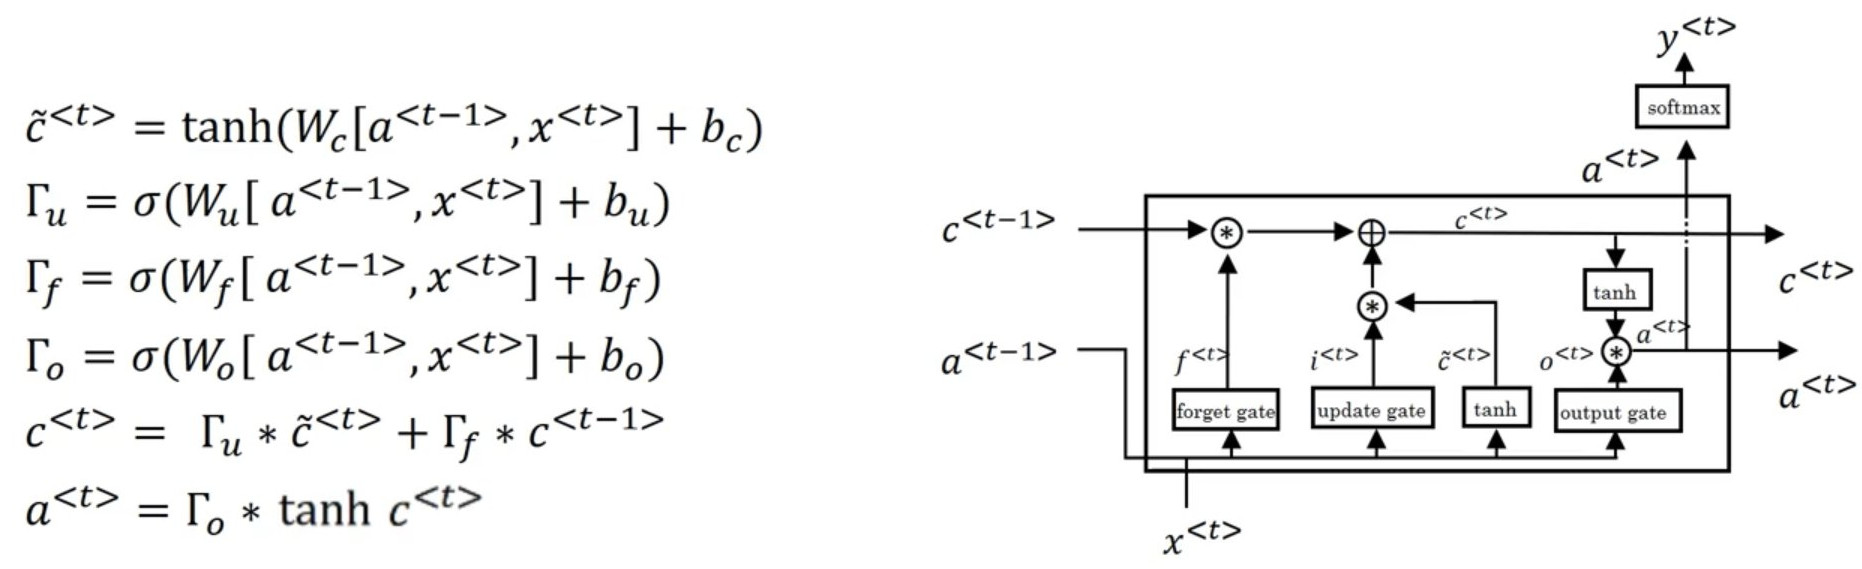

This is the architecture of an LSTM cell. At each time (sequence) step there are two "activations" passed to the cell, to determine the model (i.e. the weights of the variables in the cell $W_{u}, b_{u}, W_{f}, b_{f}, W_{o}, b_{o}, W_{c}, b_{c}$). These are $c^{t-1}, a^{t-1}$. 

In the code example the LSTM is defined by `rnn_cell.BasicLSTMCell`. It takes as an input the number of neurons to to be used by the cell. What it returns on every input $x$ it's two values. In the code of `rnn_cell.BasicLSTMCell` they are called `new_h, new_state`. `new_h` is  $a^{t}$, `new_state` is a tuple (or not depending on the `state_is_tuple` optional input of `rnn_cell.BasicLSTMCell`) which equals $(c^{t}, a^{t})$.

The `new_h` or $a^{t}$ is passed as the output of the `rnn_cell.BasicLSTMCell` since it's the actual activation (which is determined by the previous $state=(c^{t-1}, a^{t-1})$, so it depends  on the whole state not just the previous output $a^{t-1})$)

In the code the LSTM cell is created using 
```python
cell = rnn_cell.BasicLSTMCell(hidden_dim, reuse=tf.get_variable_scope().reuse,
                             name='cell')
```

`hidden_dim`, the number of neurons, defines the size of $a^{t}$, $c^{t}$. So in each time step the input to the LSTM cell can be one or more features. For example we might be processing a single timesries (one feature) or multiple timeseries (multiple features). After the input $x$ is put through the equations of the LSTM (shown in the figure) the output $a^{t}$, $c^{t}$ will have size equal to the number of neurons defined by `hidden_dim`. 

This means that the shapes of $W_{u}, W_{f}, W_{o}, W_{c}$ are the same, equal to `hidden_dim` $\times$ `hidden_dim + number_of_features` (at each time step). `number_of_features + hidden_dim` is because we stack $a^{t-1}$ and $x^{t}$ on top of each other creating a vector of dimensions `1` $\times$ `hidden_dim + number_of_features` so to get an output of dimensions the same as the activation (i.e. `hidden_dim`) we need to multiply the stacked $a^{t-1}$, $x^{t}$ vector with a weight matrix of `hidden_dim` $\times$ `hidden_dim + number_of_features` dimensions.

Note that the equations to calculate $a^{t}$, $c^{t}$ are element-wise multiplications with $\Gamma_{u}, \Gamma_{f}, \Gamma_{o}$. The $\Gamma$s are weights applied to elements of $c^{t-1}$, $\tilde{c}^{t}$ to calculate $c^{t}$, which in turn is used to calculate $a^{t}$. So the $\Gamma$s determine what magnitude of the past state ($a^{t-1}, c^{t-1}$) is passed to the current state ($a^{t}, c^{t}$). Also note that the elements of $\Gamma_{u}, \Gamma_{f}, \Gamma_{o}$ are outputs from a sigmoid $\sigma$ activation, so each element is between [0, 1] essentially each of their elements acting as a gate.

The sizes of $b_{u}, b_{f}, b_{o}, b_{c}$ are `hidden_dim`.


For more details see: 

https://www.tensorflow.org/api_docs/python/tf/nn/rnn_cell/BasicLSTMCell

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

### LSTM through sequence

An LSTM cell defines what happens at a single time step. To apply LSTM to a sequence of time observations `tensorflow` offers the `rnn.dynamic_rnn` module. 

The input data is a tensor with shape `[batch_size, max_time, number_of_features]`. `max_time` is the size of the sequence. The output of the `rnn.dynamic_rnn` is two elements called `outputs` and `state`. `outputs` is the output of the LSTM cell at each time step [batch_size, max_time, cell.output_size], where cell.output_size=`hidden_dim` from when the LSTM is defined using 
```python
cell = rnn_cell.BasicLSTMCell(hidden_dim, reuse=tf.get_variable_scope().reuse,
                             name='cell')
```
The `states` output is the state of the LSTM cell at the last time step and it's a tuple representing $a^{t}$ and $c^{t}$. $a^{t}$ can be found in the `outputs` as the last time step's `outputs`[:,-1,:], $c^{t}$ is the **hidden state** which cannot be seen in `outputs`.

The `state` might or not be useful depending on the use case. For example if you have very long sequences you might not be able to pass them whole through `rnn.dynamic_rnn` and you might split them in parts. In that case you can pass the `state` of each run to the next run of `rnn.dynamic_rnn` through the `initial_state` parameter. When the sequence is over then you can reset  `initial_state` to (usually) all zeros.

The `rnn.dynamic_rnn` is run as

```python
outputs, states = rnn.dynamic_rnn(cell, xExample, dtype=tf.float32)
```

See:

https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn

https://stackoverflow.com/questions/44162432/analysis-of-the-output-from-tf-nn-dynamic-rnn-tensorflow-function

### Transformation of LSTM network output to target

The output of the LSTM network implemented through `rnn.dynamic_rnn` is tensor with size [batch_size, max_time, hidden_dim]. Our target(s) might not not match these dimensions, this is the case in the code example below where the target $y$ is just a single value at each time step so its dimensions, for a batch are [batch_size, max_time]. So we need to transform the `outputs` of size [batch_size, max_time, hidden_dim] to [batch_size, max_time] in order to apply our cost function. This is done through matrix multiplication using the trainable variable `W_out`. 

`W_out` has initial dimensions of (hidden_dim, 1). For each example in each batch we need to perform a matrix multiplication between the `outputs` shape (per example in batch) -> (max_time, hidden_dim). So for each example we need to multiply `outputs`(max_time, hidden_dim) $\times$  `W_out` (hidden_dim, 1) to get something that matches $y$ (max_time,1). We can do this for the whole batch rather than per example using `tf`'s smart broadcasting using the following steps:

1. Add a dummy dimension to the first axis of `W_out` (hidden_dim, 1) using `tf.expand_dims(W_out, 0)`
    - Now `W_out` has shape (1, hidden_dim, 1)
2. Repeat `W_out` over each example of the batch using `tf.tile(W_out, [batch_size, 1, 1])` 
    - Now `W_out` has shape (batch_size, hidden_dim, 1) and `outputs` has shape (batch_size, max_time, hidden_dim)
3. Multiply `W_out` with `outputs` using `out=tf.matmul(outputs, W_out) + b_out`
    - This gives a tensor of shape (batch_size, max_time, 1)
4. Remove degenerate dimension using `tf.squeeze(out)`
    - The result is a tensor with shape (batch_size, max_time)
5. Now the output of the model matches the dimensions of target $y$ and we can apply a cost function using `tf.reduce_mean(tf.square(out - y))`

## Code

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell

# data
# 3 batches, 4 time steps per batch([1,2], [2,2], [5,2], [6,2]) 
# with 2 features per time step ([1,2])
train_x = [[[1,2], [2,2], [5,2], [6,2]],
           [[5,2], [7,2], [7,2], [8,2]],
           [[3,2], [4,2], [5,2], [7,2]]]

# data
# 3 batches, 2 time steps per batch([1], [6]) 
# with 1 features per time step ([1])
# train_x = [[[1], [6]],
#            [[5], [8]],
#            [[3], [7]]]

# data
# 3 batches, 4 time steps per batch([1], [2], [5], [6]) 
# with 1 feature per time step ([1])
# train_x = [[[1], [2], [5], [6]],
#            [[5], [7], [7], [8]],
#            [[3], [4], [5], [7]]]

train_y = [[1, 3, 7, 11],
           [5, 12, 14, 15],
           [3, 7, 9, 12]]

hidden_dim=10
seq_size=4
input_dim=2

# Weight variables and input placeholders
W_out = tf.Variable(tf.random_normal([hidden_dim, 1]), name='W_out')
b_out = tf.Variable(tf.random_normal([1]), name='b_out')
with tf.Session() as sess:
    # initialise 
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    # Get example data
    xExample = tf.convert_to_tensor(train_x, dtype=tf.float32)
    cell = rnn_cell.BasicLSTMCell(hidden_dim, 
                                  reuse=tf.get_variable_scope().reuse,
                                 name='cell')
    # rnn.dynamic_rnn creates an RNN based on the provided cell
    print('*************************')
    print('Input shape is (batch_size, time_steps, \
    number of features per time step) {}'.format(xExample.shape))
    outputs, states = rnn.dynamic_rnn(cell, xExample, dtype=tf.float32)
    sess.run(tf.global_variables_initializer())
    print('*************************')
    print('Outputs (activations at each time step)\n \
          shape is (batch_size, sequence_length, \
          cell_state_size) {}'.format(outputs.shape))
#     print(sess.run(outputs))
    print('*************************')
    # c=3x10, a=3x10
    print('States (hidden state c) shape is: {}'\
          .format(states[0].shape))
    print('States (activation state a) shape is: {}'\
          .format(states[1].shape))
#     print(sess.run(states))
    num_examples = tf.shape(xExample)[0]
    print('*************************')
    print('Number of examples per batch is: {}'\
          .format(sess.run(num_examples)))
    #tf.expand_dims(W_out, 0) add a degenerate 
    #dimension to the first axis of `W_out`
    print('*************************')
    print('Dimensions of W_out: {}'.format(W_out.shape))    
    W_out_new=tf.expand_dims(W_out, 0)
    print('Dimensions of W_out_new: {}'.format(W_out_new.shape))  
    W_repeated = tf.tile(W_out_new, [num_examples, 1, 1],
                         name='W_repeated')
    sess.run(tf.global_variables_initializer())
    print('Dimensions of W_repeated: {}'.format(W_repeated.shape))  
    out = tf.matmul(outputs, W_repeated) + b_out
    print('Dimensions of out: {}'.format(out.shape))
    out = tf.identity(out, name="out")
    outSqueeze = tf.squeeze(out, name="outSqueezed")
    print('Dimensions of outSqueeze: {}'.format(outSqueeze.shape))
    sess.run(tf.global_variables_initializer())
    train_y_tensor = tf.convert_to_tensor(train_y, dtype=tf.float32)
    print('Dimensions of target: {}'.format(train_y_tensor.shape))
    cost = tf.reduce_mean(tf.square(outSqueeze - train_y_tensor))
    print('*************************')
    print('Value of cost: {}'.format(sess.run(cost)))

*************************
Input shape is (batch_size, time_steps, number of features per time step) (3, 4, 2)
*************************
Outputs (activations at each time step)
           shape is (batch_size, sequence_length, cell_state_size) (3, 4, 10)
*************************
States (hidden state c) shape is: (3, 10)
States (activation state a) shape is: (3, 10)
*************************
Number of examples per batch is: 3
*************************
Dimensions of W_out: (10, 1)
Dimensions of W_out_new: (1, 10, 1)
Dimensions of W_repeated: (?, 10, 1)
Dimensions of out: (3, 4, 1)
Dimensions of outSqueeze: (3, 4)
Dimensions of target: (3, 4)
*************************
Value of cost: 82.54722595214844
